In [10]:
import linopy
import pandas as pd
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
from pathlib import Path
from shapely import wkt

In [11]:
xr_ref = xr.open_dataset('Output_SolarWind\\xr_final_SI_combined_SolarWind_exc.nc')

In [12]:
mwperkm2_wind = 4.5 ## originally 9 MW/km2 but deduct by 50% of the technically available from IEA's Thailand CET
mwperkm2_solar = 15 ## originally 30 MW/km2 but deduct by 50% of the technically available from IEA's Thailand CET

In [13]:
SPP_maxcap_wind = 90
SPP_mincap_wind = 16
VSPP_maxcap_wind = 10
VSPP_mincap_wind = 1

SPP_maxcap_solar = 90
SPP_mincap_solar = 15
VSPP_maxcap_solar = 10
VSPP_mincap_solar = 1

In [14]:
######## PDP ############################################################
SPP_quota_wind_total =  5335
SPP_quota_wind_R0 = 0
SPP_quota_wind_R1 = 0
SPP_quota_wind_R2 = 5115
SPP_quota_wind_R3 =  220
SPP_quota_wind_R4 =  0

VSPP_quota_wind_total =  0
VSPP_quota_wind_R0 =  0
VSPP_quota_wind_R1 =  0
VSPP_quota_wind_R2 =  0
VSPP_quota_wind_R3 =  0
VSPP_quota_wind_R4 = 0

SPP_quota_solar_total =  18810
SPP_quota_solar_R0 =  0
SPP_quota_solar_R1 =  3150
SPP_quota_solar_R2 =  3060
SPP_quota_solar_R3 = 8100
SPP_quota_solar_R4 =  4500

VSPP_quota_solar_total = 0
VSPP_quota_solar_R0 = 0
VSPP_quota_solar_R1 =  0
VSPP_quota_solar_R2 =  0
VSPP_quota_solar_R3 =   0
VSPP_quota_solar_R4 =  0
######## PDP ############################################################

In [15]:
######################## model #####################################################
m = linopy.Model()

SPP_built_wind = m.add_variables(integer=True,upper=1000,lower=0, coords=xr_ref.coords, name='SPP_built_wind')
VSPP_built_wind = m.add_variables(integer=True,upper=1000,lower=0, coords=xr_ref.coords, name='VSPP_built_wind')
SPP_built_solar = m.add_variables(integer=True,upper=1000,lower=0, coords=xr_ref.coords, name='SPP_built_solar')
VSPP_built_solar = m.add_variables(integer=True,upper=1000,lower=0, coords=xr_ref.coords, name='VSPP_built_solar')

SPP_area_wind = m.add_variables(lower=0.0000, coords=xr_ref.coords, name='SPP_area_wind')
VSPP_area_wind = m.add_variables(lower=0.0000, coords=xr_ref.coords, name='VSPP_area_wind')
SPP_area_solar = m.add_variables(lower=0.0000, coords=xr_ref.coords, name='SPP_area_solar')
VSPP_area_solar = m.add_variables(lower=0.0000, coords=xr_ref.coords, name='VSPP_area_solar')

In [16]:
constr_built_logic = m.add_constraints((SPP_built_wind + VSPP_built_wind + SPP_built_solar + VSPP_built_solar) <=  1000, name='constr_built_logic')

constr_area_wind = m.add_constraints((SPP_area_wind + VSPP_area_wind) <= (xr_ref['wind_area']), name='constr_area_wind')
constr_SPP_area_wind = m.add_constraints(SPP_area_wind <= (xr_ref['wind_area']), name='constr_SPP_area_wind')
constr_VSPP_area_wind = m.add_constraints(VSPP_area_wind <= (xr_ref['wind_area']), name='constr_VSPP_area_wind')

constr_area_solar = m.add_constraints((SPP_area_solar + VSPP_area_solar) <= (xr_ref['solar_area']), name='constr_area_solar')
constr_SPP_area_solar = m.add_constraints(SPP_area_solar  <= (xr_ref['solar_area']), name='constr_SPP_area_solar')
constr_VSPP_area_solar = m.add_constraints(VSPP_area_solar  <= (xr_ref['solar_area']), name='constr_VSPP_area_solar')

constr_area = m.add_constraints((SPP_area_wind + VSPP_area_wind + SPP_area_solar + VSPP_area_solar) <= (xr_ref['area']), name='constr_area')

constr_SPP_capacity_wind_max = m.add_constraints((SPP_area_wind*mwperkm2_wind) <= (SPP_maxcap_wind*SPP_built_wind), name='constr_SPP_capacity_wind_max')
constr_SPP_capacity_wind_min = m.add_constraints((SPP_area_wind*mwperkm2_wind) >= (SPP_mincap_wind*SPP_built_wind), name='constr_SPP_capacity_wind_min')
constr_VSPP_capacity_wind_max = m.add_constraints((VSPP_area_wind*mwperkm2_wind) <= (VSPP_maxcap_wind*VSPP_built_wind), name='constr_VSPP_capacity_wind_max')
constr_VSPP_capacity_wind_min = m.add_constraints((VSPP_area_wind*mwperkm2_wind) >= (VSPP_mincap_wind*VSPP_built_wind), name='constr_VSPP_capacity_wind_min')

constr_SPP_capacity_solar_max = m.add_constraints((SPP_area_solar*mwperkm2_solar) <= (SPP_maxcap_solar*SPP_built_solar), name='constr_SPP_capacity_solar_max')
constr_SPP_capacity_solar_min = m.add_constraints((SPP_area_solar*mwperkm2_solar) >= (SPP_mincap_solar*SPP_built_solar), name='constr_SPP_capacity_solar_min')
constr_VSPP_capacity_solar_max = m.add_constraints((VSPP_area_solar*mwperkm2_solar) <= (VSPP_maxcap_solar*VSPP_built_solar), name='constr_VSPP_capacity_solar_max')
constr_VSPP_capacity_solar_min = m.add_constraints((VSPP_area_solar*mwperkm2_solar) >= (VSPP_mincap_solar*VSPP_built_solar), name='constr_VSPP_capacity_solar_min')


In [17]:
############################################################################################################################################################

constr_SPP_quota_wind = m.add_constraints((SPP_area_wind.sum()) * mwperkm2_wind >= SPP_quota_wind_total , name='constr_SPP_quota_wind')

constr_SPP_quota_wind_r0 = m.add_constraints(lhs = (SPP_area_wind*mwperkm2_wind).where(xr_ref['region'] == 'R0',drop=True).sum()
                                             , sign = '>=' , rhs = SPP_quota_wind_R0, name='constr_SPP_quota_wind_r0')

constr_SPP_quota_wind_r1 = m.add_constraints(lhs = (SPP_area_wind*mwperkm2_wind).where(xr_ref['region'] == 'R1',drop=True).sum()
                                             , sign = '>=' , rhs = SPP_quota_wind_R1, name='constr_SPP_quota_wind_r1')

constr_SPP_quota_wind_r2 = m.add_constraints(lhs = (SPP_area_wind*mwperkm2_wind).where(xr_ref['region'] == 'R2',drop=True).sum()
                                             , sign = '>=' , rhs = SPP_quota_wind_R2, name='constr_SPP_quota_wind_r2')

constr_SPP_quota_wind_r3 = m.add_constraints(lhs = (SPP_area_wind*mwperkm2_wind).where(xr_ref['region'] == 'R3',drop=True).sum()
                                             , sign = '>=' , rhs = SPP_quota_wind_R3, name='constr_SPP_quota_wind_r3')

constr_SPP_quota_wind_r4 = m.add_constraints(lhs = (SPP_area_wind*mwperkm2_wind).where(xr_ref['region'] == 'R4',drop=True).sum()
                                             , sign = '>=' , rhs = SPP_quota_wind_R4, name='constr_SPP_quota_wind_r4')

############################################################################################################################################################

constr_VSPP_quota_wind = m.add_constraints((VSPP_area_wind.sum()) * mwperkm2_wind >= VSPP_quota_wind_total , name='constr_VSPP_quota_wind')

constr_VSPP_quota_wind_r0 = m.add_constraints(lhs = (VSPP_area_wind*mwperkm2_wind).where(xr_ref['region'] == 'R0',drop=True).sum()
                                             , sign = '>=' , rhs = VSPP_quota_wind_R0, name='constr_VSPP_quota_wind_r0')

constr_VSPP_quota_wind_r1 = m.add_constraints(lhs = (VSPP_area_wind*mwperkm2_wind).where(xr_ref['region'] == 'R1',drop=True).sum()
                                             , sign = '>=' , rhs = VSPP_quota_wind_R1, name='constr_VSPP_quota_wind_r1')

constr_VSPP_quota_wind_r2 = m.add_constraints(lhs = (VSPP_area_wind*mwperkm2_wind).where(xr_ref['region'] == 'R2',drop=True).sum()
                                             , sign = '>=' , rhs = VSPP_quota_wind_R2, name='constr_VSPP_quota_wind_r2')

constr_VSPP_quota_wind_r3 = m.add_constraints(lhs = (VSPP_area_wind*mwperkm2_wind).where(xr_ref['region'] == 'R3',drop=True).sum()
                                             , sign = '>=' , rhs = VSPP_quota_wind_R3, name='constr_VSPP_quota_wind_r3')

constr_VSPP_quota_wind_r4 = m.add_constraints(lhs = (VSPP_area_wind*mwperkm2_wind).where(xr_ref['region'] == 'R4',drop=True).sum()
                                             , sign = '>=' , rhs = VSPP_quota_wind_R4, name='constr_VSPP_quota_wind_r4')
############################################################################################################################################################

constr_SPP_quota_solar = m.add_constraints((SPP_area_solar.sum()) * mwperkm2_solar >= SPP_quota_solar_total, name='constr_SPP_quota_solar')

constr_SPP_quota_solar_r0 = m.add_constraints(lhs = (SPP_area_solar*mwperkm2_solar).where(xr_ref['region'] == 'R0',drop=True).sum()
                                             , sign = '>=' , rhs = SPP_quota_solar_R0, name='constr_SPP_quota_solar_r0')

constr_SPP_quota_solar_r1 = m.add_constraints(lhs = (SPP_area_solar*mwperkm2_solar).where(xr_ref['region'] == 'R1',drop=True).sum()
                                             , sign = '>=' , rhs = SPP_quota_solar_R1, name='constr_SPP_quota_solar_r1')

constr_SPP_quota_solar_r2 = m.add_constraints(lhs = (SPP_area_solar*mwperkm2_solar).where(xr_ref['region'] == 'R2',drop=True).sum()
                                             , sign = '>=' , rhs = SPP_quota_solar_R2, name='constr_SPP_quota_solar_r2')

constr_SPP_quota_solar_r3 = m.add_constraints(lhs = (SPP_area_solar*mwperkm2_solar).where(xr_ref['region'] == 'R3',drop=True).sum()
                                             , sign = '>=' , rhs = SPP_quota_solar_R3, name='constr_SPP_quota_solar_r3')

constr_SPP_quota_solar_r4 = m.add_constraints(lhs = (SPP_area_solar*mwperkm2_solar).where(xr_ref['region'] == 'R4',drop=True).sum()
                                             , sign = '>=' , rhs = SPP_quota_solar_R4, name='constr_SPP_quota_solar_r4')

############################################################################################################################################################

constr_VSPP_quota_solar = m.add_constraints((VSPP_area_solar.sum()) * mwperkm2_solar >= VSPP_quota_solar_total, name='constr_VSPP_quota_solar')

constr_VSPP_quota_solar_r0 = m.add_constraints(lhs = (VSPP_area_solar*mwperkm2_solar).where(xr_ref['region'] == 'R0',drop=True).sum()
                                             , sign = '>=' , rhs = VSPP_quota_solar_R0, name='constr_VSPP_quota_solar_r0')

constr_VSPP_quota_solar_r1 = m.add_constraints(lhs = (VSPP_area_solar*mwperkm2_solar).where(xr_ref['region'] == 'R1',drop=True).sum()
                                             , sign = '>=' , rhs = VSPP_quota_solar_R1, name='constr_VSPP_quota_solar_r1')

constr_VSPP_quota_solar_r2 = m.add_constraints(lhs = (VSPP_area_solar*mwperkm2_solar).where(xr_ref['region'] == 'R2',drop=True).sum()
                                             , sign = '>=' , rhs = VSPP_quota_solar_R2, name='constr_VSPP_quota_solar_r2')

constr_VSPP_quota_solar_r3 = m.add_constraints(lhs = (VSPP_area_solar*mwperkm2_solar).where(xr_ref['region'] == 'R3',drop=True).sum()
                                             , sign = '>=' , rhs = VSPP_quota_solar_R3, name='constr_VSPP_quota_solar_r3')

constr_VSPP_quota_solar_r4 = m.add_constraints(lhs = (VSPP_area_solar*mwperkm2_solar).where(xr_ref['region'] == 'R4',drop=True).sum()
                                             , sign = '>=' , rhs = VSPP_quota_solar_R4, name='constr_VSPP_quota_solar_r4')

############################################################################################################################################################


In [18]:
obj = (-1000) * (
    (((SPP_built_wind) + (SPP_area_wind/xr_ref['wind_area'])) * xr_ref['wind_SI']).where(xr_ref['wind_area'] > 0,drop=True).sum()
    + (((VSPP_built_wind) + (VSPP_area_wind/xr_ref['wind_area'])) * xr_ref['wind_SI']).where(xr_ref['wind_area'] > 0,drop=True).sum()
    + (((SPP_built_solar) + (SPP_area_solar/xr_ref['solar_area'])) * xr_ref['solar_SI']).where(xr_ref['solar_area'] > 0,drop=True).sum()
    + (((VSPP_built_solar) + (VSPP_area_solar/xr_ref['solar_area'])) * xr_ref['solar_SI']).where(xr_ref['solar_area'] > 0,drop=True).sum()
)

m.add_objective(obj)

In [19]:
print("presolve = ",m)

presolve =  Linopy MILP model

Variables:
----------
 * SPP_built_wind (index)
 * VSPP_built_wind (index)
 * SPP_built_solar (index)
 * VSPP_built_solar (index)
 * SPP_area_wind (index)
 * VSPP_area_wind (index)
 * SPP_area_solar (index)
 * VSPP_area_solar (index)

Constraints:
------------
 * constr_built_logic (index)
 * constr_area_wind (index)
 * constr_SPP_area_wind (index)
 * constr_VSPP_area_wind (index)
 * constr_area_solar (index)
 * constr_SPP_area_solar (index)
 * constr_VSPP_area_solar (index)
 * constr_area (index)
 * constr_SPP_capacity_wind_max (index)
 * constr_SPP_capacity_wind_min (index)
 * constr_VSPP_capacity_wind_max (index)
 * constr_VSPP_capacity_wind_min (index)
 * constr_SPP_capacity_solar_max (index)
 * constr_SPP_capacity_solar_min (index)
 * constr_VSPP_capacity_solar_max (index)
 * constr_VSPP_capacity_solar_min (index)
 * constr_SPP_quota_wind
 * constr_SPP_quota_wind_r0
 * constr_SPP_quota_wind_r1
 * constr_SPP_quota_wind_r2
 * constr_SPP_quota_wind_r3
 

In [20]:
m.solve(solver_name='highs',
        mip_abs_gap = 0.0018,
        mip_rel_gap = 0.0018,
        )

print('aftersolve = ',m)
solution = m.solution
solution = solution.fillna(0)
solution.to_netcdf(path='Output_SolarWind\\InvestmentMap_SolarWind.nc')
print(solution)

Writing integer variables.: 100%|██████████| 4/4 [00:00<00:00, 54.94it/s]


aftersolve =  Linopy MILP model

Variables:
----------
 * SPP_built_wind (index)
 * VSPP_built_wind (index)
 * SPP_built_solar (index)
 * VSPP_built_solar (index)
 * SPP_area_wind (index)
 * VSPP_area_wind (index)
 * SPP_area_solar (index)
 * VSPP_area_solar (index)

Constraints:
------------
 * constr_built_logic (index)
 * constr_area_wind (index)
 * constr_SPP_area_wind (index)
 * constr_VSPP_area_wind (index)
 * constr_area_solar (index)
 * constr_SPP_area_solar (index)
 * constr_VSPP_area_solar (index)
 * constr_area (index)
 * constr_SPP_capacity_wind_max (index)
 * constr_SPP_capacity_wind_min (index)
 * constr_VSPP_capacity_wind_max (index)
 * constr_VSPP_capacity_wind_min (index)
 * constr_SPP_capacity_solar_max (index)
 * constr_SPP_capacity_solar_min (index)
 * constr_VSPP_capacity_solar_max (index)
 * constr_VSPP_capacity_solar_min (index)
 * constr_SPP_quota_wind
 * constr_SPP_quota_wind_r0
 * constr_SPP_quota_wind_r1
 * constr_SPP_quota_wind_r2
 * constr_SPP_quota_wind_r3

In [21]:
xr_sol = xr.open_dataset('Output_SolarWind\\InvestmentMap_SolarWind.nc')
df_ref = pd.read_csv('Output_SolarWind\\df_final_SI_combined_SolarWind_exc.csv')
df_ref = df_ref.drop_duplicates('pol_id')
xr_sol.close()
mwperkm2_wind = 4.5 ## originally 9 MW/km2 but deduct by 50% of the technically available
mwperkm2_solar = 15 ## originally 30 MW/km2 but deduct by 50% of the technically available
print(df_ref)

       index  pol_id                                           geometry  \
0          0       0  POLYGON ((100.10833333333338 20.41666666666667...   
1          1       1  POLYGON ((99.9916666666667 20.369444444444447,...   
2          2       2  POLYGON ((100.10833333333338 20.37500000000000...   
3          3       3  POLYGON ((99.95833333333337 20.355555555555558...   
4          4       4  POLYGON ((99.9166666666667 20.33888888888889, ...   
...      ...     ...                                                ...   
16259  16259   17001  POLYGON ((101.88888888888893 5.933333333333335...   
16260  16260   17002  POLYGON ((101.83611111111115 5.930555555555556...   
16261  16261   17003  POLYGON ((101.88888888888893 5.916666666666669...   
16262  16262   17004  POLYGON ((101.87500000000003 5.908333333333333...   
16263  16263   17005  POLYGON ((101.12777777777781 5.883333333333335...   

         area  from_pol_wind_id   wind_SI  wind_area  \
0      8.2634                 1  1.817748  

In [22]:
df_sol= xr_sol.to_dataframe()
df_sol.reset_index(inplace=True)
print(df_sol)

df = pd.merge(df_ref,df_sol,how='inner',on='index')
print(df)

       index  SPP_built_wind  VSPP_built_wind  SPP_built_solar  \
0          0             0.0             -0.0              0.0   
1          1             0.0             -0.0              0.0   
2          2             0.0              0.0              0.0   
3          3             0.0              0.0              0.0   
4          4             0.0              0.0              0.0   
...      ...             ...              ...              ...   
16259  16259             0.0              0.0              0.0   
16260  16260             0.0              0.0              0.0   
16261  16261             0.0              0.0              0.0   
16262  16262             0.0              0.0              0.0   
16263  16263             0.0              0.0              0.0   

       VSPP_built_solar  SPP_area_wind  VSPP_area_wind  SPP_area_solar  \
0                 123.0            0.0            -0.0             0.0   
1                  91.0            0.0            -0.0     

In [23]:
print(df.columns)

Index(['index', 'pol_id', 'geometry', 'area', 'from_pol_wind_id', 'wind_SI',
       'wind_area', 'wind_area_coord', 'from_pol_solar_id', 'solar_SI',
       'solar_area', 'solar_area_coord', 'ADM1_EN', 'ADM1_TH', 'region',
       'contain_exs', 'SPP_built_wind', 'VSPP_built_wind', 'SPP_built_solar',
       'VSPP_built_solar', 'SPP_area_wind', 'VSPP_area_wind', 'SPP_area_solar',
       'VSPP_area_solar'],
      dtype='object')


In [24]:
df['geometry'] = df['geometry'].apply(wkt.loads)
df = gpd.GeoDataFrame(df, crs='epsg:4326')
df = df.set_geometry(df['geometry'])
df['capacity_wind'] = (df['SPP_area_wind'] + df['VSPP_area_wind']) * mwperkm2_wind
df['capacity_vspp_wind'] = (df['VSPP_area_wind']) * mwperkm2_wind
df['capacity_spp_wind'] = (df['SPP_area_wind']) * mwperkm2_wind

df['capacity_solar'] = (df['SPP_area_solar'] + df['VSPP_area_solar']) * mwperkm2_solar
df['capacity_vspp_solar'] = (df['VSPP_area_solar']) * mwperkm2_solar
df['capacity_spp_solar'] = (df['SPP_area_solar']) * mwperkm2_solar

df.to_csv('Output_SolarWind\\InvestmentMap_SolarWind.csv',index=False,encoding="utf-8-sig")

In [25]:
print("wind total = ",round(df['capacity_wind'].sum(),2))

print("SPP wind total = ",round(df['capacity_spp_wind'].sum(),2))
print("SPP wind R0 = ",round(df['capacity_spp_wind'].loc[(df['region'] == 'R0')].sum(),2))
print("SPP wind R1 = ",round(df['capacity_spp_wind'].loc[(df['region'] == 'R1')].sum(),2))
print("SPP wind R2 = ",round(df['capacity_spp_wind'].loc[(df['region'] == 'R2')].sum(),2))
print("SPP wind R3 = ",round(df['capacity_spp_wind'].loc[(df['region'] == 'R3')].sum(),2))
print("SPP wind R4 = ",round(df['capacity_spp_wind'].loc[(df['region'] == 'R4')].sum(),2))

print("VSPP wind total = ",round(df['capacity_vspp_wind'].sum(),2))
print("VSPP wind R0 = ",round(df['capacity_vspp_wind'].loc[(df['region'] == 'R0')].sum(),2))
print("VSPP wind R1 = ",round(df['capacity_vspp_wind'].loc[(df['region'] == 'R1')].sum(),2))
print("VSPP wind R2 = ",round(df['capacity_vspp_wind'].loc[(df['region'] == 'R2')].sum(),2))
print("VSPP wind R3 = ",round(df['capacity_vspp_wind'].loc[(df['region'] == 'R3')].sum(),2))
print("VSPP wind R4 = ",round(df['capacity_vspp_wind'].loc[(df['region'] == 'R4')].sum(),2))

print("solar total = ",round(df['capacity_solar'].sum(),2))

print("SPP solar total = ",round(df['capacity_spp_solar'].sum(),2))
print("SPP solar R0 = ",round(df['capacity_spp_solar'].loc[(df['region'] == 'R0')].sum(),2))
print("SPP solar R1 = ",round(df['capacity_spp_solar'].loc[(df['region'] == 'R1')].sum(),2))
print("SPP solar R2 = ",round(df['capacity_spp_solar'].loc[(df['region'] == 'R2')].sum(),2))
print("SPP solar R3 = ",round(df['capacity_spp_solar'].loc[(df['region'] == 'R3')].sum(),2))
print("SPP solar R4 = ",round(df['capacity_spp_solar'].loc[(df['region'] == 'R4')].sum(),2))

print("VSPP solar total = ",round(df['capacity_vspp_solar'].sum(),2))
print("VSPP solar R0 = ",round(df['capacity_vspp_solar'].loc[(df['region'] == 'R0')].sum(),2))
print("VSPP solar R1 = ",round(df['capacity_vspp_solar'].loc[(df['region'] == 'R1')].sum(),2))
print("VSPP solar R2 = ",round(df['capacity_vspp_solar'].loc[(df['region'] == 'R2')].sum(),2))
print("VSPP solar R3 = ",round(df['capacity_vspp_solar'].loc[(df['region'] == 'R3')].sum(),2))
print("VSPP solar R4 = ",round(df['capacity_vspp_solar'].loc[(df['region'] == 'R4')].sum(),2))



print("Max wind capacity = ",round(df['capacity_wind'].max(),2))
print("Min wind capacity = ",round(df['capacity_wind'].loc[df['capacity_wind']>0].min(),2))
print("Max solar capacity = ",round(df['capacity_solar'].max(),2))
print("Min solar capacity = ",round(df['capacity_solar'].loc[df['capacity_solar']>0].min(),2))

wind total =  8341.25
SPP wind total =  5657.33
SPP wind R0 =  0.0
SPP wind R1 =  64.35
SPP wind R2 =  5115.0
SPP wind R3 =  224.02
SPP wind R4 =  253.96
VSPP wind total =  2683.93
VSPP wind R0 =  0.0
VSPP wind R1 =  292.35
VSPP wind R2 =  1556.58
VSPP wind R3 =  835.0
VSPP wind R4 =  0.0
solar total =  1245343.18
SPP solar total =  37723.85
SPP solar R0 =  0.0
SPP solar R1 =  6744.91
SPP solar R2 =  9460.75
SPP solar R3 =  8100.0
SPP solar R4 =  13418.2
VSPP solar total =  1207619.33
VSPP solar R0 =  709.18
VSPP solar R1 =  207782.58
VSPP solar R2 =  592040.38
VSPP solar R3 =  124407.38
VSPP solar R4 =  282679.81
Max wind capacity =  1296.73
Min wind capacity =  0.0
Max solar capacity =  3759.7
Min solar capacity =  0.0


c:\Users\EGAT\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


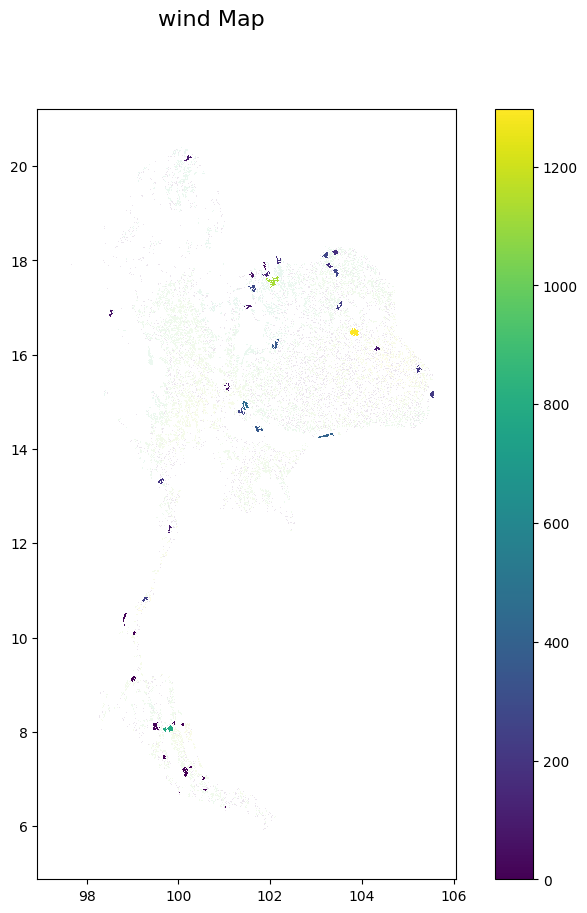

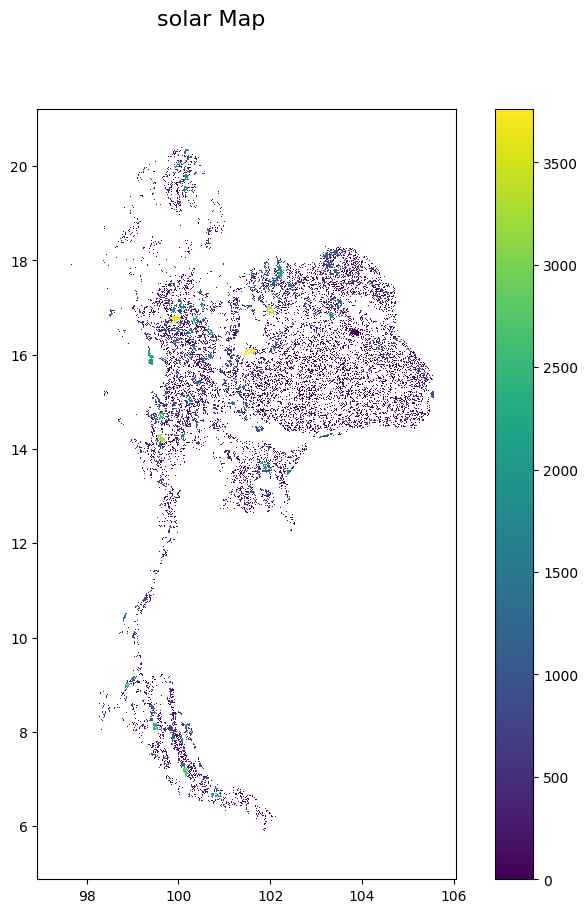

In [31]:
thailandmap = gpd.read_file('Data\\tha_admbnda_adm1_rtsd_20220121\\tha_admbnda_adm1_rtsd_20220121.shp')
thailandmap.crs = {'init': 'epsg:4326'}
try:
    fig, ax = plt.subplots(figsize=(10,10))
    fig.suptitle('wind Map', fontsize=16)
    thailandmap.plot(ax = ax, color='none', edgecolor = 'white', zorder = 0)
    df.plot(ax = ax,column = 'wind_SI', alpha = 0.1, zorder = 1)
    df.loc[df['capacity_wind']>0].plot(ax = ax,legend=True,zorder = 2,column = 'capacity_wind')
except:
    None
try:
    fig, ax = plt.subplots(figsize=(10,10))
    fig.suptitle('solar Map', fontsize=16)
    thailandmap.plot(ax = ax, color='none', edgecolor = 'white', zorder = 0)
    df.plot(ax = ax,column = 'solar_SI', alpha = 0.1, zorder = 1)
    df.loc[df['capacity_solar']>0].plot(ax = ax,legend=True,zorder = 3,column = 'capacity_solar')
except:
    None

c:\Users\EGAT\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


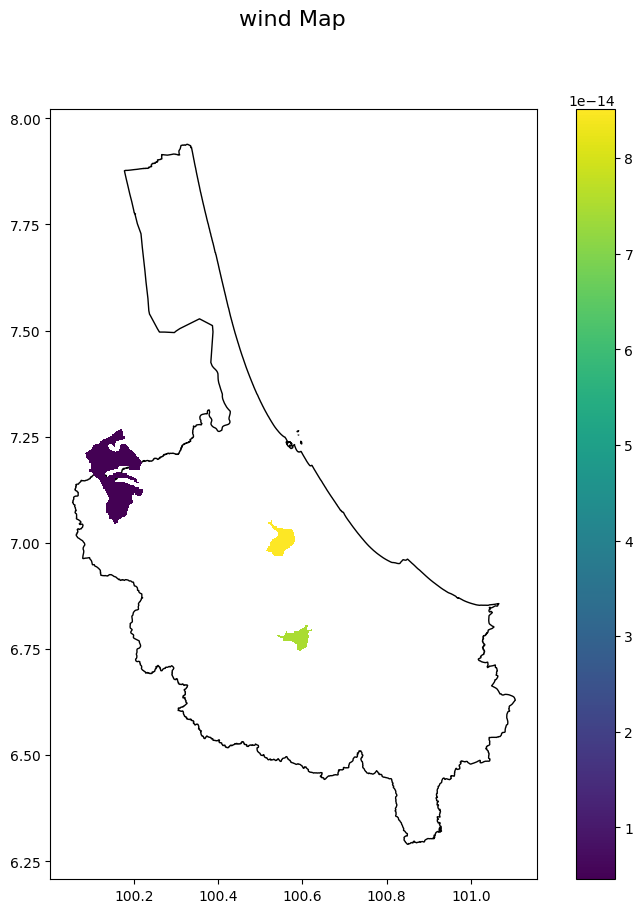

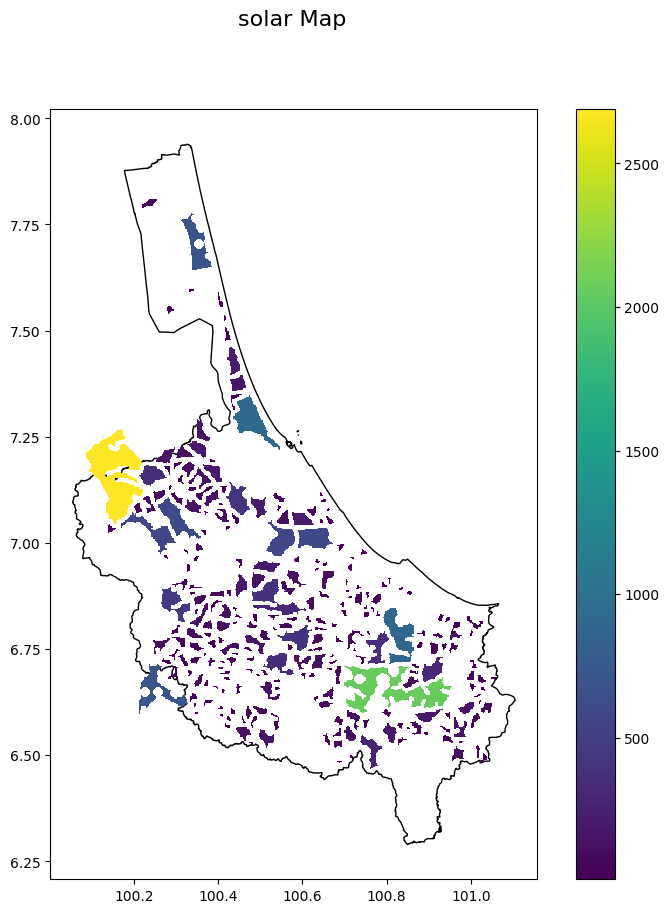

In [32]:
province = 'Songkhla'
thailandmap = gpd.read_file('Data\\tha_admbnda_adm1_rtsd_20220121\\tha_admbnda_adm1_rtsd_20220121.shp')
thailandmap.crs = {'init': 'epsg:4326'}
specificarea = thailandmap.loc[thailandmap['ADM1_EN'] == province]
bound = specificarea.unary_union.bounds


try:
    fig, ax = plt.subplots(figsize=(10,10))
    fig.suptitle('wind Map', fontsize=16)
    specificarea.plot(ax = ax, color='none', edgecolor = 'black', zorder = 0)
    df.loc[(df['capacity_wind'] > 0) & (df['ADM1_EN'] == province)].plot(ax = ax,legend=True,zorder = 2,column = 'capacity_wind')
except:
    None
try:
    fig, ax = plt.subplots(figsize=(10,10))
    fig.suptitle('solar Map', fontsize=16)
    specificarea.plot(ax = ax, color='none', edgecolor = 'black', zorder = 0)
    df.loc[(df['capacity_solar'] > 0) & (df['ADM1_EN'] == province)].plot(ax = ax,legend=True,zorder = 3,column = 'capacity_solar')
except:
    None